In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical stock price data using yfinance
ticker = "AAPL"  # Example: Apple Inc.
start_date = "2023-01-01"
end_date = "2024-01-01"

# Get the stock data
data = yf.download(ticker, start=start_date, end=end_date)
S_train = data['Close'].values
num_samples = len(S_train)

# Fetch historical options data
options_data = yf.Ticker(ticker).options
expiration_date = options_data[0]  # Get the nearest expiration date
options_chain = yf.Ticker(ticker).option_chain(expiration_date)

# Combine calls and puts
options_df = pd.concat([options_chain.calls, options_chain.puts], ignore_index=True)

# Print the columns to understand the structure
print("Options DataFrame Columns:", options_df.columns)

# Check if 'strike', 'impliedVolatility', and 'expiration' are present
if 'strike' in options_df.columns and 'impliedVolatility' in options_df.columns:
    # Filter for relevant columns
    K = options_df['strike'].values  # Strike prices
    implied_volatility = options_df['impliedVolatility'].values  # Implied volatilities

    # Get expiration date
    expiration_date = pd.to_datetime(expiration_date)  # Convert to datetime
    current_date = pd.to_datetime('today')
    
    # Calculate time to expiration (t) in years
    t_train = (expiration_date - current_date).days / 365.0  # Time to expiration in years
    t_train = np.full_like(K, t_train)  # Create an array with the same length as K

    # Ensure data sizes match
    min_length = min(len(S_train), len(K), len(implied_volatility))
    S_train = S_train[:min_length]
    K = K[:min_length]
    implied_volatility = implied_volatility[:min_length]
    t_train = t_train[:min_length]
else:
    raise KeyError("Required columns 'strike' or 'impliedVolatility' not found in options data.")

# Convert data to PyTorch tensors and reshape
S_train_tensor = torch.tensor(S_train, dtype=torch.float32).view(-1, 1)  # Shape (num_samples, 1)
t_train_tensor = torch.tensor(t_train, dtype=torch.float32).view(-1, 1)  # Shape (num_samples, 1)
implied_volatility_tensor = torch.tensor(implied_volatility, dtype=torch.float32).view(-1, 1)  # Shape (num_samples, 1)
K_tensor = torch.tensor(K, dtype=torch.float32).view(-1, 1)  # Shape (num_samples, 1)

# Check tensor data types and shapes
print(f"S_train_tensor dtype: {S_train_tensor.dtype}, shape: {S_train_tensor.shape}")
print(f"t_train_tensor dtype: {t_train_tensor.dtype}, shape: {t_train_tensor.shape}")
print(f"K_tensor dtype: {K_tensor.dtype}, shape: {K_tensor.shape}")
print(f"Implied volatility dtype: {implied_volatility_tensor.dtype}, shape: {implied_volatility_tensor.shape}")

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(3, 50)  # Input size is 3: S, t, and sigma
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, S, t, sigma):
        x = torch.cat((S, t, sigma), dim=1)  # Concatenate inputs
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        return self.output(x)

# Initialize the neural network
model = PINN()

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Train the model
n_epochs = 1000
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    option_prices = model(S_train_tensor, t_train_tensor, implied_volatility_tensor)
    
    # Compute the Black-Scholes prices (define this function as needed)
    bs_prices = black_scholes_call(S_train_tensor, K_tensor, t_train_tensor, r=0.05, sigma=implied_volatility_tensor)
    
    # Calculate loss
    loss = loss_function(option_prices, bs_prices.view(-1, 1))
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# After training, you can predict option prices
with torch.no_grad():
    predicted_prices = model(S_train_tensor, t_train_tensor, implied_volatility_tensor)

print(f"Predicted option prices: {predicted_prices.squeeze().numpy()}")


[*********************100%***********************]  1 of 1 completed


Options DataFrame Columns: Index(['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask',
       'change', 'percentChange', 'volume', 'openInterest',
       'impliedVolatility', 'inTheMoney', 'contractSize', 'currency'],
      dtype='object')
S_train_tensor dtype: torch.float32, shape: torch.Size([97, 1])
t_train_tensor dtype: torch.float32, shape: torch.Size([97, 1])
K_tensor dtype: torch.float32, shape: torch.Size([97, 1])
Implied volatility dtype: torch.float32, shape: torch.Size([97, 1])
Epoch 0, Loss: 147.43008422851562
Epoch 100, Loss: 106.04278564453125
Epoch 200, Loss: 103.56645965576172
Epoch 300, Loss: 94.09435272216797
Epoch 400, Loss: 65.40436553955078
Epoch 500, Loss: 49.9560546875
Epoch 600, Loss: 48.23655319213867
Epoch 700, Loss: 47.4011344909668
Epoch 800, Loss: 46.354270935058594
Epoch 900, Loss: 45.36310577392578
Predicted option prices: [ 3.27784309e+01  3.39824791e+01  2.55464268e+01  2.00952110e+01
  2.05155544e+01  1.49878464e+01  4.67176139e-02  

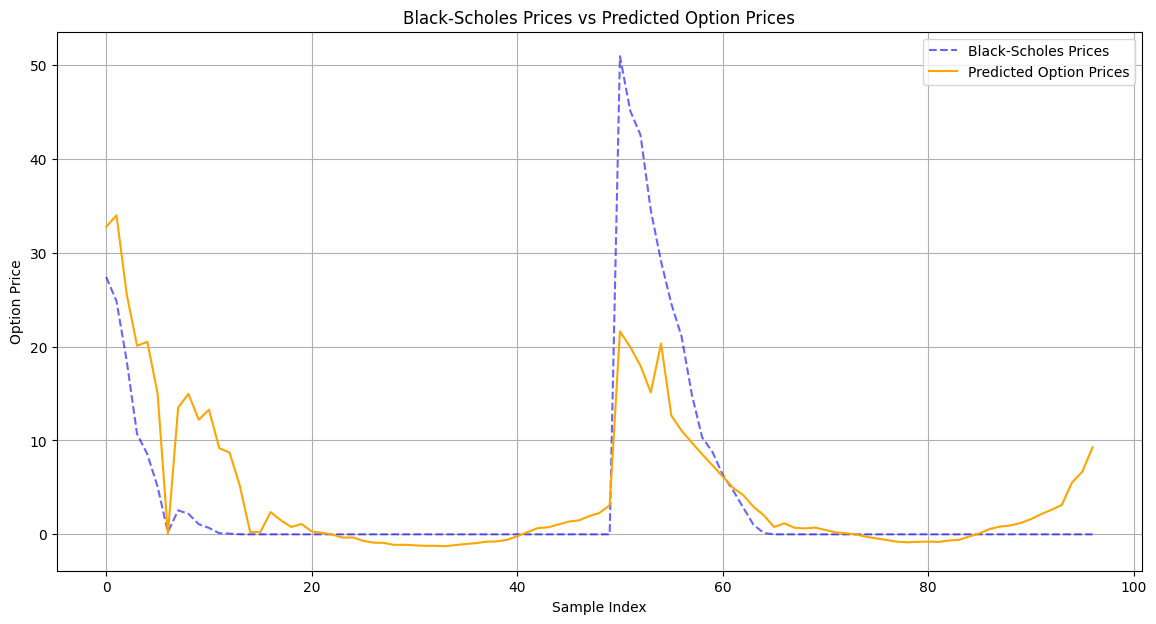

In [37]:
# Visualization
plt.figure(figsize=(14, 7))
plt.plot(bs_prices.numpy(), label='Black-Scholes Prices', color='blue', linestyle='--', alpha=0.6)
plt.plot(predicted_prices.numpy(), label='Predicted Option Prices', color='orange')
plt.title('Black-Scholes Prices vs Predicted Option Prices')
plt.xlabel('Sample Index')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()